# Week 16 - Day 4: Deep Q-Networks (DQN)

## Learning Objectives
- Understand neural networks as Q-function approximators
- Implement experience replay for stable learning
- Use target networks to reduce training instability
- Build a complete DQN trading agent

## Overview
Deep Q-Networks (DQN) combine Q-learning with deep neural networks to handle high-dimensional state spaces. This breakthrough by DeepMind (2015) enabled RL agents to learn directly from raw inputs and has significant applications in algorithmic trading.

**Key Innovations:**
1. **Neural Network Q-Function**: Approximate Q(s,a) with a deep neural network
2. **Experience Replay**: Store and sample past experiences to break correlation
3. **Target Network**: Separate network for stable Q-value targets

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Using device: cpu


---
## Part 1: Neural Network as Q-Function

### The Q-Function Approximation Problem

In traditional Q-learning, we maintain a table $Q(s, a)$ for all state-action pairs. This becomes infeasible when:
- State space is continuous (e.g., stock prices, technical indicators)
- State space is high-dimensional

**Solution**: Use a neural network $Q(s, a; \theta)$ to approximate the Q-function:

$$Q(s, a; \theta) \approx Q^*(s, a)$$

### Network Architecture for Trading

For trading, our network takes market features as input and outputs Q-values for each action:
- **Input**: State vector (prices, returns, indicators, position)
- **Output**: Q-values for [Hold, Buy, Sell]

In [2]:
class QNetwork(nn.Module):
    """
    Deep Q-Network for trading.
    
    Architecture:
    - Input layer: state_size features
    - Hidden layers with ReLU activation
    - Output layer: Q-values for each action
    """
    
    def __init__(self, state_size: int, action_size: int, hidden_sizes: List[int] = [128, 64]):
        """
        Initialize the Q-Network.
        
        Args:
            state_size: Dimension of state space
            action_size: Number of possible actions
            hidden_sizes: List of hidden layer sizes
        """
        super(QNetwork, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        
        # Build network layers
        layers = []
        input_size = state_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))  # Regularization
            input_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(input_size, action_size))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize network weights using Xavier initialization."""
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.
        
        Args:
            state: State tensor of shape (batch_size, state_size)
            
        Returns:
            Q-values for each action, shape (batch_size, action_size)
        """
        return self.network(state)


# Demonstrate the Q-Network
print("=" * 60)
print("Q-NETWORK ARCHITECTURE")
print("=" * 60)

# Example: 10 features, 3 actions (Hold, Buy, Sell)
state_size = 10
action_size = 3

q_network = QNetwork(state_size, action_size, hidden_sizes=[128, 64]).to(device)
print(q_network)

# Test forward pass
sample_state = torch.randn(1, state_size).to(device)
q_values = q_network(sample_state)
print(f"\nInput state shape: {sample_state.shape}")
print(f"Output Q-values shape: {q_values.shape}")
print(f"Q-values: {q_values.detach().cpu().numpy()}")
print(f"Best action: {q_values.argmax().item()} (0=Hold, 1=Buy, 2=Sell)")

Q-NETWORK ARCHITECTURE
QNetwork(
  (network): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)

Input state shape: torch.Size([1, 10])
Output Q-values shape: torch.Size([1, 3])
Q-values: [[-0.14516908 -0.13765356  0.2325585 ]]
Best action: 2 (0=Hold, 1=Buy, 2=Sell)


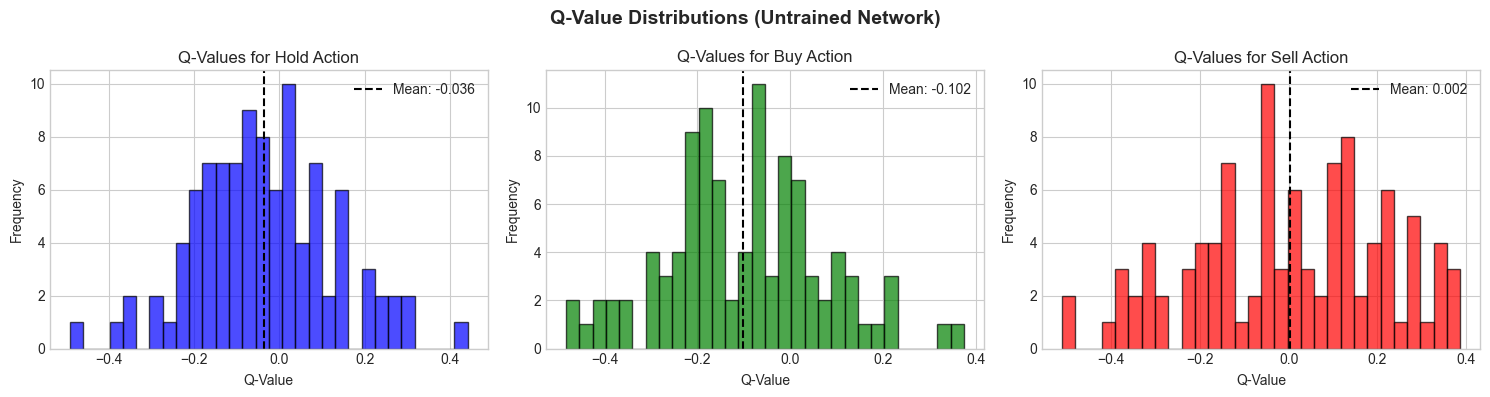


Action Selection Distribution (untrained):
  Hold: 37 (37.0%)
  Buy: 19 (19.0%)
  Sell: 44 (44.0%)


In [3]:
# Visualize how Q-Network processes different states
def visualize_q_values(network, num_samples=100):
    """Visualize Q-value distributions for random states."""
    
    network.eval()
    states = torch.randn(num_samples, state_size).to(device)
    
    with torch.no_grad():
        q_values = network(states).cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    actions = ['Hold', 'Buy', 'Sell']
    colors = ['blue', 'green', 'red']
    
    for i, (ax, action, color) in enumerate(zip(axes, actions, colors)):
        ax.hist(q_values[:, i], bins=30, color=color, alpha=0.7, edgecolor='black')
        ax.axvline(q_values[:, i].mean(), color='black', linestyle='--', 
                   label=f'Mean: {q_values[:, i].mean():.3f}')
        ax.set_xlabel('Q-Value')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Q-Values for {action} Action')
        ax.legend()
    
    plt.suptitle('Q-Value Distributions (Untrained Network)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Show action selection
    best_actions = q_values.argmax(axis=1)
    action_counts = np.bincount(best_actions, minlength=3)
    
    print(f"\nAction Selection Distribution (untrained):")
    for i, (action, count) in enumerate(zip(actions, action_counts)):
        print(f"  {action}: {count} ({100*count/num_samples:.1f}%)")

visualize_q_values(q_network)

---
## Part 2: Experience Replay

### The Problem with Online Learning

Training a neural network directly on sequential experiences causes:
1. **Correlation**: Consecutive samples are highly correlated
2. **Forgetting**: Network forgets earlier experiences
3. **Instability**: Non-stationary data distribution

### Solution: Experience Replay Buffer

Store experiences $(s, a, r, s', done)$ in a buffer and sample random mini-batches:

**Benefits:**
- Breaks temporal correlations
- Reuses past experiences efficiently
- Smooths learning by averaging over many past behaviors

In [4]:
# Named tuple for storing experiences
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])


class ReplayBuffer:
    """
    Experience Replay Buffer for storing and sampling experiences.
    
    Uses a circular buffer (deque) for efficient memory management.
    """
    
    def __init__(self, capacity: int = 100000):
        """
        Initialize replay buffer.
        
        Args:
            capacity: Maximum number of experiences to store
        """
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity
    
    def push(self, state: np.ndarray, action: int, reward: float, 
             next_state: np.ndarray, done: bool):
        """Add experience to buffer."""
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size: int) -> Tuple[torch.Tensor, ...]:
        """
        Sample a random batch of experiences.
        
        Args:
            batch_size: Number of experiences to sample
            
        Returns:
            Tuple of tensors (states, actions, rewards, next_states, dones)
        """
        experiences = random.sample(self.buffer, batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(np.array([e.state for e in experiences])).to(device)
        actions = torch.LongTensor(np.array([e.action for e in experiences])).to(device)
        rewards = torch.FloatTensor(np.array([e.reward for e in experiences])).to(device)
        next_states = torch.FloatTensor(np.array([e.next_state for e in experiences])).to(device)
        dones = torch.FloatTensor(np.array([e.done for e in experiences])).to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self) -> int:
        return len(self.buffer)
    
    def is_ready(self, batch_size: int) -> bool:
        """Check if buffer has enough samples."""
        return len(self.buffer) >= batch_size


# Demonstrate replay buffer
print("=" * 60)
print("EXPERIENCE REPLAY BUFFER")
print("=" * 60)

replay_buffer = ReplayBuffer(capacity=10000)

# Add some fake experiences
for i in range(500):
    state = np.random.randn(state_size)
    action = np.random.randint(0, action_size)
    reward = np.random.randn()
    next_state = np.random.randn(state_size)
    done = np.random.random() < 0.1
    
    replay_buffer.push(state, action, reward, next_state, done)

print(f"Buffer size: {len(replay_buffer)}")
print(f"Buffer capacity: {replay_buffer.capacity}")
print(f"Ready for batch of 64: {replay_buffer.is_ready(64)}")

# Sample a batch
states, actions, rewards, next_states, dones = replay_buffer.sample(32)
print(f"\nSampled batch shapes:")
print(f"  States: {states.shape}")
print(f"  Actions: {actions.shape}")
print(f"  Rewards: {rewards.shape}")
print(f"  Next states: {next_states.shape}")
print(f"  Dones: {dones.shape}")

EXPERIENCE REPLAY BUFFER
Buffer size: 500
Buffer capacity: 10000
Ready for batch of 64: True

Sampled batch shapes:
  States: torch.Size([32, 10])
  Actions: torch.Size([32])
  Rewards: torch.Size([32])
  Next states: torch.Size([32, 10])
  Dones: torch.Size([32])


In [5]:
class PrioritizedReplayBuffer:
    """
    Prioritized Experience Replay Buffer.
    
    Samples experiences based on their TD-error priority,
    focusing learning on more "surprising" experiences.
    """
    
    def __init__(self, capacity: int = 100000, alpha: float = 0.6, beta: float = 0.4):
        """
        Args:
            capacity: Maximum buffer size
            alpha: Priority exponent (0 = uniform, 1 = full prioritization)
            beta: Importance sampling exponent
        """
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        self.max_priority = 1.0
    
    def push(self, state, action, reward, next_state, done):
        """Add experience with max priority."""
        experience = Experience(state, action, reward, next_state, done)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
        
        # New experiences get max priority
        self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size: int) -> Tuple[torch.Tensor, ..., np.ndarray]:
        """Sample based on priorities."""
        if len(self.buffer) == 0:
            raise ValueError("Buffer is empty")
        
        # Calculate sampling probabilities
        priorities = self.priorities[:len(self.buffer)]
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        # Sample indices based on priorities
        indices = np.random.choice(len(self.buffer), batch_size, p=probs, replace=False)
        
        # Importance sampling weights
        weights = (len(self.buffer) * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        
        # Get experiences
        experiences = [self.buffer[idx] for idx in indices]
        
        states = torch.FloatTensor(np.array([e.state for e in experiences])).to(device)
        actions = torch.LongTensor(np.array([e.action for e in experiences])).to(device)
        rewards = torch.FloatTensor(np.array([e.reward for e in experiences])).to(device)
        next_states = torch.FloatTensor(np.array([e.next_state for e in experiences])).to(device)
        dones = torch.FloatTensor(np.array([e.done for e in experiences])).to(device)
        weights = torch.FloatTensor(weights).to(device)
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    def update_priorities(self, indices: np.ndarray, td_errors: np.ndarray):
        """Update priorities based on TD-errors."""
        for idx, td_error in zip(indices, td_errors):
            priority = abs(td_error) + 1e-6  # Small constant for stability
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return len(self.buffer)


print("\n" + "=" * 60)
print("PRIORITIZED EXPERIENCE REPLAY")
print("=" * 60)
print("Prioritized replay samples important experiences more often.")
print("Priority is based on TD-error magnitude.")


PRIORITIZED EXPERIENCE REPLAY
Prioritized replay samples important experiences more often.
Priority is based on TD-error magnitude.


---
## Part 3: Target Networks

### The Moving Target Problem

In Q-learning, we update using the Bellman equation:

$$Q(s, a) \leftarrow r + \gamma \max_{a'} Q(s', a')$$

When using a neural network, updating $Q(s, a; \theta)$ also changes $Q(s', a'; \theta)$, creating a **moving target** that causes instability.

### Solution: Separate Target Network

Maintain two networks:
1. **Online Network** $Q(s, a; \theta)$: Updated every step
2. **Target Network** $Q(s, a; \theta^-)$: Updated periodically (copied from online)

**Loss function:**
$$L(\theta) = \mathbb{E}\left[\left(r + \gamma \max_{a'} Q(s', a'; \theta^-) - Q(s, a; \theta)\right)^2\right]$$

In [6]:
def create_target_network(online_network: nn.Module) -> nn.Module:
    """
    Create a target network as a copy of the online network.
    
    Args:
        online_network: The network to copy
        
    Returns:
        A copy of the network with the same weights
    """
    target_network = QNetwork(
        online_network.state_size,
        online_network.action_size
    ).to(device)
    
    # Copy weights
    target_network.load_state_dict(online_network.state_dict())
    
    # Freeze target network (no gradient computation)
    for param in target_network.parameters():
        param.requires_grad = False
    
    return target_network


def hard_update(online_network: nn.Module, target_network: nn.Module):
    """
    Hard update: Copy all weights from online to target network.
    
    Used periodically (e.g., every 1000 steps).
    """
    target_network.load_state_dict(online_network.state_dict())


def soft_update(online_network: nn.Module, target_network: nn.Module, tau: float = 0.005):
    """
    Soft update: Slowly blend online weights into target network.
    
    θ_target = τ * θ_online + (1 - τ) * θ_target
    
    Args:
        tau: Interpolation parameter (0.001 to 0.01 typically)
    """
    for target_param, online_param in zip(target_network.parameters(), 
                                          online_network.parameters()):
        target_param.data.copy_(tau * online_param.data + (1 - tau) * target_param.data)


# Demonstrate target network
print("=" * 60)
print("TARGET NETWORK UPDATES")
print("=" * 60)

online_net = QNetwork(state_size, action_size).to(device)
target_net = create_target_network(online_net)

# Check that weights are identical
def compare_networks(net1, net2):
    """Compare if two networks have identical weights."""
    for p1, p2 in zip(net1.parameters(), net2.parameters()):
        if not torch.equal(p1, p2):
            return False
    return True

print(f"Networks identical after copy: {compare_networks(online_net, target_net)}")

# Simulate training (change online network)
optimizer = optim.Adam(online_net.parameters(), lr=0.001)
sample_state = torch.randn(32, state_size).to(device)
target_q = torch.randn(32, action_size).to(device)

# One training step
optimizer.zero_grad()
pred_q = online_net(sample_state)
loss = F.mse_loss(pred_q, target_q)
loss.backward()
optimizer.step()

print(f"Networks identical after training: {compare_networks(online_net, target_net)}")

# Soft update
soft_update(online_net, target_net, tau=0.1)
print(f"Networks identical after soft update (tau=0.1): {compare_networks(online_net, target_net)}")

TARGET NETWORK UPDATES
Networks identical after copy: True
Networks identical after training: False
Networks identical after soft update (tau=0.1): False


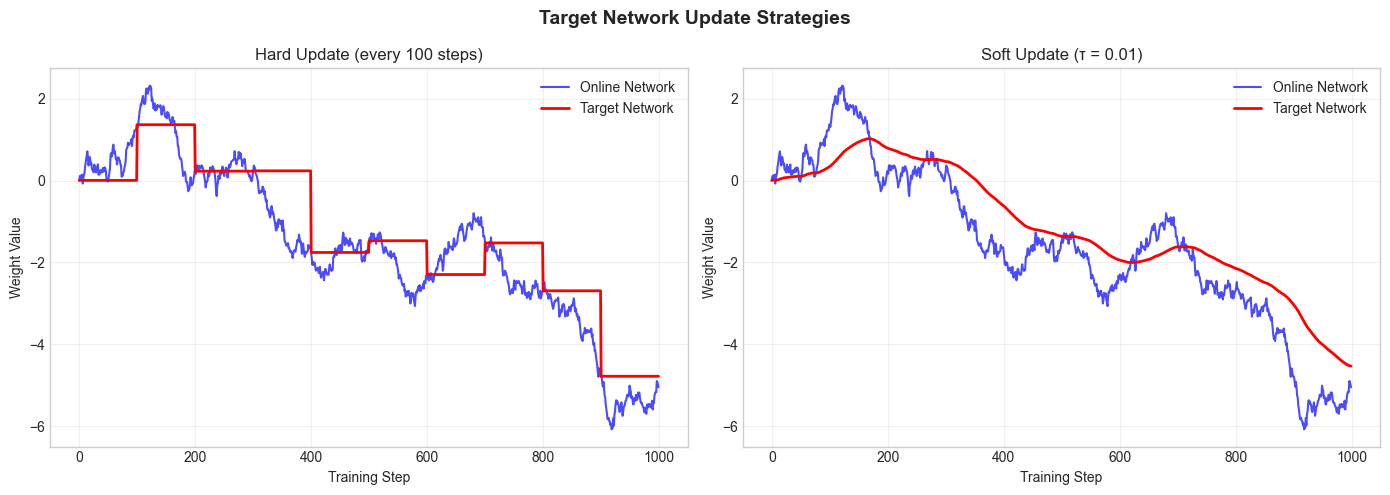

In [7]:
# Visualize target network update strategies
def visualize_update_strategies():
    """Compare hard vs soft update strategies."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    steps = 1000
    update_freq = 100  # Hard update frequency
    tau = 0.01  # Soft update parameter
    
    # Simulate online weight changing
    online_weights = np.cumsum(np.random.randn(steps) * 0.1)  # Random walk
    
    # Hard update tracking
    hard_target = np.zeros(steps)
    current_target = 0
    for i in range(steps):
        if i % update_freq == 0:
            current_target = online_weights[i]
        hard_target[i] = current_target
    
    # Soft update tracking
    soft_target = np.zeros(steps)
    soft_target[0] = online_weights[0]
    for i in range(1, steps):
        soft_target[i] = tau * online_weights[i] + (1 - tau) * soft_target[i-1]
    
    # Plot hard update
    axes[0].plot(online_weights, 'b-', alpha=0.7, label='Online Network')
    axes[0].plot(hard_target, 'r-', linewidth=2, label='Target Network')
    axes[0].set_xlabel('Training Step')
    axes[0].set_ylabel('Weight Value')
    axes[0].set_title(f'Hard Update (every {update_freq} steps)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot soft update
    axes[1].plot(online_weights, 'b-', alpha=0.7, label='Online Network')
    axes[1].plot(soft_target, 'r-', linewidth=2, label='Target Network')
    axes[1].set_xlabel('Training Step')
    axes[1].set_ylabel('Weight Value')
    axes[1].set_title(f'Soft Update (τ = {tau})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Target Network Update Strategies', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_update_strategies()

---
## Part 4: Complete DQN Trading Implementation

Now we'll combine all components into a complete DQN trading agent:

1. **Trading Environment**: Simulates market with state/reward
2. **DQN Agent**: Neural network with experience replay and target network
3. **Training Loop**: Epsilon-greedy exploration with gradual decay

In [8]:
class TradingEnvironment:
    """
    Simulated trading environment for DQN training.
    
    State: [returns_t-4, ..., returns_t, volatility, momentum, position]
    Actions: 0=Hold, 1=Buy, 2=Sell
    Reward: Portfolio return with transaction costs
    """
    
    def __init__(self, prices: np.ndarray, window_size: int = 5, 
                 transaction_cost: float = 0.001):
        """
        Initialize trading environment.
        
        Args:
            prices: Array of historical prices
            window_size: Number of past returns in state
            transaction_cost: Cost per trade as fraction
        """
        self.prices = prices
        self.returns = np.diff(prices) / prices[:-1]
        self.window_size = window_size
        self.transaction_cost = transaction_cost
        
        # State size: window_size returns + volatility + momentum + position
        self.state_size = window_size + 3
        self.action_size = 3  # Hold, Buy, Sell
        
        self.reset()
    
    def reset(self) -> np.ndarray:
        """Reset environment to initial state."""
        self.current_step = self.window_size
        self.position = 0  # -1=Short, 0=Flat, 1=Long
        self.portfolio_value = 1.0
        self.history = []
        return self._get_state()
    
    def _get_state(self) -> np.ndarray:
        """Construct state vector."""
        # Past returns
        past_returns = self.returns[self.current_step - self.window_size:self.current_step]
        
        # Volatility (rolling std)
        volatility = np.std(past_returns)
        
        # Momentum (sum of recent returns)
        momentum = np.sum(past_returns)
        
        # Combine into state
        state = np.concatenate([
            past_returns,
            [volatility, momentum, self.position]
        ])
        
        return state.astype(np.float32)
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, dict]:
        """
        Execute one step in the environment.
        
        Args:
            action: 0=Hold, 1=Buy, 2=Sell
            
        Returns:
            next_state, reward, done, info
        """
        # Get current return
        current_return = self.returns[self.current_step]
        
        # Calculate position change and transaction cost
        old_position = self.position
        
        if action == 1:  # Buy
            self.position = 1
        elif action == 2:  # Sell
            self.position = -1
        # action == 0: Hold (no change)
        
        # Transaction cost for position change
        position_change = abs(self.position - old_position)
        cost = position_change * self.transaction_cost
        
        # Calculate reward: position * return - costs
        reward = self.position * current_return - cost
        
        # Update portfolio value
        self.portfolio_value *= (1 + reward)
        
        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.returns) - 1
        
        # Record history
        self.history.append({
            'step': self.current_step,
            'action': action,
            'position': self.position,
            'return': current_return,
            'reward': reward,
            'portfolio_value': self.portfolio_value
        })
        
        next_state = self._get_state() if not done else np.zeros(self.state_size)
        
        info = {
            'portfolio_value': self.portfolio_value,
            'position': self.position
        }
        
        return next_state, reward, done, info
    
    def render(self):
        """Display current state."""
        positions = {-1: 'Short', 0: 'Flat', 1: 'Long'}
        print(f"Step: {self.current_step}, Position: {positions[self.position]}, "
              f"Portfolio: ${self.portfolio_value:.4f}")


# Generate synthetic price data
def generate_prices(n_steps: int = 1000, mu: float = 0.0001, sigma: float = 0.02) -> np.ndarray:
    """Generate synthetic price data with geometric Brownian motion."""
    returns = np.random.normal(mu, sigma, n_steps)
    prices = 100 * np.exp(np.cumsum(returns))
    return prices


# Test environment
print("=" * 60)
print("TRADING ENVIRONMENT")
print("=" * 60)

prices = generate_prices(500)
env = TradingEnvironment(prices, window_size=5)

print(f"State size: {env.state_size}")
print(f"Action size: {env.action_size}")

state = env.reset()
print(f"\nInitial state: {state}")

# Take a few random actions
print("\nTaking random actions:")
for i in range(5):
    action = np.random.randint(0, 3)
    next_state, reward, done, info = env.step(action)
    actions = ['Hold', 'Buy', 'Sell']
    print(f"  Action: {actions[action]}, Reward: {reward:.4f}, Portfolio: ${info['portfolio_value']:.4f}")

TRADING ENVIRONMENT
State size: 8
Action size: 3

Initial state: [ 8.6278786e-05  2.0385481e-02  1.5382086e-02  1.5407301e-02
 -4.4548078e-03  9.7082173e-03  4.6806339e-02  0.0000000e+00]

Taking random actions:
  Action: Hold, Reward: 0.0000, Portfolio: $1.0000
  Action: Sell, Reward: -0.0169, Portfolio: $0.9831
  Action: Hold, Reward: 0.0015, Portfolio: $0.9846
  Action: Buy, Reward: 0.0037, Portfolio: $0.9883
  Action: Hold, Reward: 0.0158, Portfolio: $1.0039


In [9]:
class DQNAgent:
    """
    Deep Q-Network Agent for Trading.
    
    Combines:
    - Q-Network for action-value estimation
    - Target network for stable learning
    - Experience replay for sample efficiency
    - Epsilon-greedy exploration
    """
    
    def __init__(self, state_size: int, action_size: int,
                 learning_rate: float = 0.001,
                 gamma: float = 0.99,
                 epsilon_start: float = 1.0,
                 epsilon_end: float = 0.01,
                 epsilon_decay: float = 0.995,
                 buffer_size: int = 100000,
                 batch_size: int = 64,
                 target_update_freq: int = 100,
                 use_soft_update: bool = True,
                 tau: float = 0.005):
        """
        Initialize DQN Agent.
        
        Args:
            state_size: Dimension of state space
            action_size: Number of actions
            learning_rate: Learning rate for optimizer
            gamma: Discount factor
            epsilon_start: Initial exploration rate
            epsilon_end: Minimum exploration rate
            epsilon_decay: Decay rate for epsilon
            buffer_size: Replay buffer capacity
            batch_size: Mini-batch size for training
            target_update_freq: Steps between target network updates
            use_soft_update: Use soft update instead of hard update
            tau: Soft update parameter
        """
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.use_soft_update = use_soft_update
        self.tau = tau
        
        # Networks
        self.online_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.online_network.state_dict())
        
        # Optimizer
        self.optimizer = optim.Adam(self.online_network.parameters(), lr=learning_rate)
        
        # Replay buffer
        self.memory = ReplayBuffer(buffer_size)
        
        # Training tracking
        self.training_step = 0
        self.losses = []
    
    def select_action(self, state: np.ndarray, training: bool = True) -> int:
        """
        Select action using epsilon-greedy policy.
        
        Args:
            state: Current state
            training: If True, use epsilon-greedy; if False, use greedy
            
        Returns:
            Selected action
        """
        if training and random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        
        self.online_network.eval()
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.online_network(state_tensor)
            action = q_values.argmax().item()
        self.online_network.train()
        
        return action
    
    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer."""
        self.memory.push(state, action, reward, next_state, done)
    
    def train_step(self) -> Optional[float]:
        """
        Perform one training step.
        
        Returns:
            Loss value if training occurred, None otherwise
        """
        if not self.memory.is_ready(self.batch_size):
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Compute current Q values
        current_q = self.online_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute target Q values
        with torch.no_grad():
            next_q = self.target_network(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss
        loss = F.smooth_l1_loss(current_q, target_q)  # Huber loss
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_network.parameters(), 1.0)  # Gradient clipping
        self.optimizer.step()
        
        # Update target network
        self.training_step += 1
        if self.use_soft_update:
            soft_update(self.online_network, self.target_network, self.tau)
        elif self.training_step % self.target_update_freq == 0:
            hard_update(self.online_network, self.target_network)
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        
        loss_value = loss.item()
        self.losses.append(loss_value)
        
        return loss_value
    
    def save(self, filepath: str):
        """Save model weights."""
        torch.save({
            'online_network': self.online_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'training_step': self.training_step
        }, filepath)
    
    def load(self, filepath: str):
        """Load model weights."""
        checkpoint = torch.load(filepath)
        self.online_network.load_state_dict(checkpoint['online_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.training_step = checkpoint['training_step']


print("=" * 60)
print("DQN AGENT INITIALIZED")
print("=" * 60)

agent = DQNAgent(
    state_size=env.state_size,
    action_size=env.action_size,
    learning_rate=0.001,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    batch_size=64
)

print(f"State size: {agent.state_size}")
print(f"Action size: {agent.action_size}")
print(f"Initial epsilon: {agent.epsilon}")
print(f"Batch size: {agent.batch_size}")

DQN AGENT INITIALIZED
State size: 8
Action size: 3
Initial epsilon: 1.0
Batch size: 64


In [10]:
def train_dqn(agent: DQNAgent, env: TradingEnvironment, 
              n_episodes: int = 200, verbose: bool = True) -> dict:
    """
    Train DQN agent on trading environment.
    
    Args:
        agent: DQN agent to train
        env: Trading environment
        n_episodes: Number of training episodes
        verbose: Print progress
        
    Returns:
        Training history dictionary
    """
    history = {
        'episode_rewards': [],
        'episode_values': [],
        'epsilons': [],
        'avg_losses': []
    }
    
    for episode in range(n_episodes):
        state = env.reset()
        episode_reward = 0
        episode_losses = []
        done = False
        
        while not done:
            # Select and execute action
            action = agent.select_action(state, training=True)
            next_state, reward, done, info = env.step(action)
            
            # Store experience
            agent.store_experience(state, action, reward, next_state, done)
            
            # Train
            loss = agent.train_step()
            if loss is not None:
                episode_losses.append(loss)
            
            episode_reward += reward
            state = next_state
        
        # Record episode stats
        history['episode_rewards'].append(episode_reward)
        history['episode_values'].append(info['portfolio_value'])
        history['epsilons'].append(agent.epsilon)
        history['avg_losses'].append(np.mean(episode_losses) if episode_losses else 0)
        
        if verbose and (episode + 1) % 20 == 0:
            avg_reward = np.mean(history['episode_rewards'][-20:])
            avg_value = np.mean(history['episode_values'][-20:])
            print(f"Episode {episode + 1}/{n_episodes} | "
                  f"Avg Reward: {avg_reward:.4f} | "
                  f"Avg Portfolio: ${avg_value:.4f} | "
                  f"Epsilon: {agent.epsilon:.4f}")
    
    return history


# Train the agent
print("=" * 60)
print("TRAINING DQN AGENT")
print("=" * 60)

# Generate training data
train_prices = generate_prices(1000, mu=0.0002, sigma=0.02)
train_env = TradingEnvironment(train_prices, window_size=5)

# Create agent
agent = DQNAgent(
    state_size=train_env.state_size,
    action_size=train_env.action_size,
    learning_rate=0.0005,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.998,
    batch_size=64,
    use_soft_update=True,
    tau=0.005
)

# Train
history = train_dqn(agent, train_env, n_episodes=150, verbose=True)

TRAINING DQN AGENT
Episode 20/150 | Avg Reward: 1.2076 | Avg Portfolio: $5.6590 | Epsilon: 0.0100
Episode 40/150 | Avg Reward: 4.6324 | Avg Portfolio: $107.1030 | Epsilon: 0.0100
Episode 60/150 | Avg Reward: 5.9432 | Avg Portfolio: $355.0652 | Epsilon: 0.0100
Episode 80/150 | Avg Reward: 6.5143 | Avg Portfolio: $589.6839 | Epsilon: 0.0100
Episode 100/150 | Avg Reward: 6.8246 | Avg Portfolio: $824.5415 | Epsilon: 0.0100
Episode 120/150 | Avg Reward: 6.9574 | Avg Portfolio: $971.4055 | Epsilon: 0.0100
Episode 140/150 | Avg Reward: 6.6497 | Avg Portfolio: $673.0231 | Epsilon: 0.0100


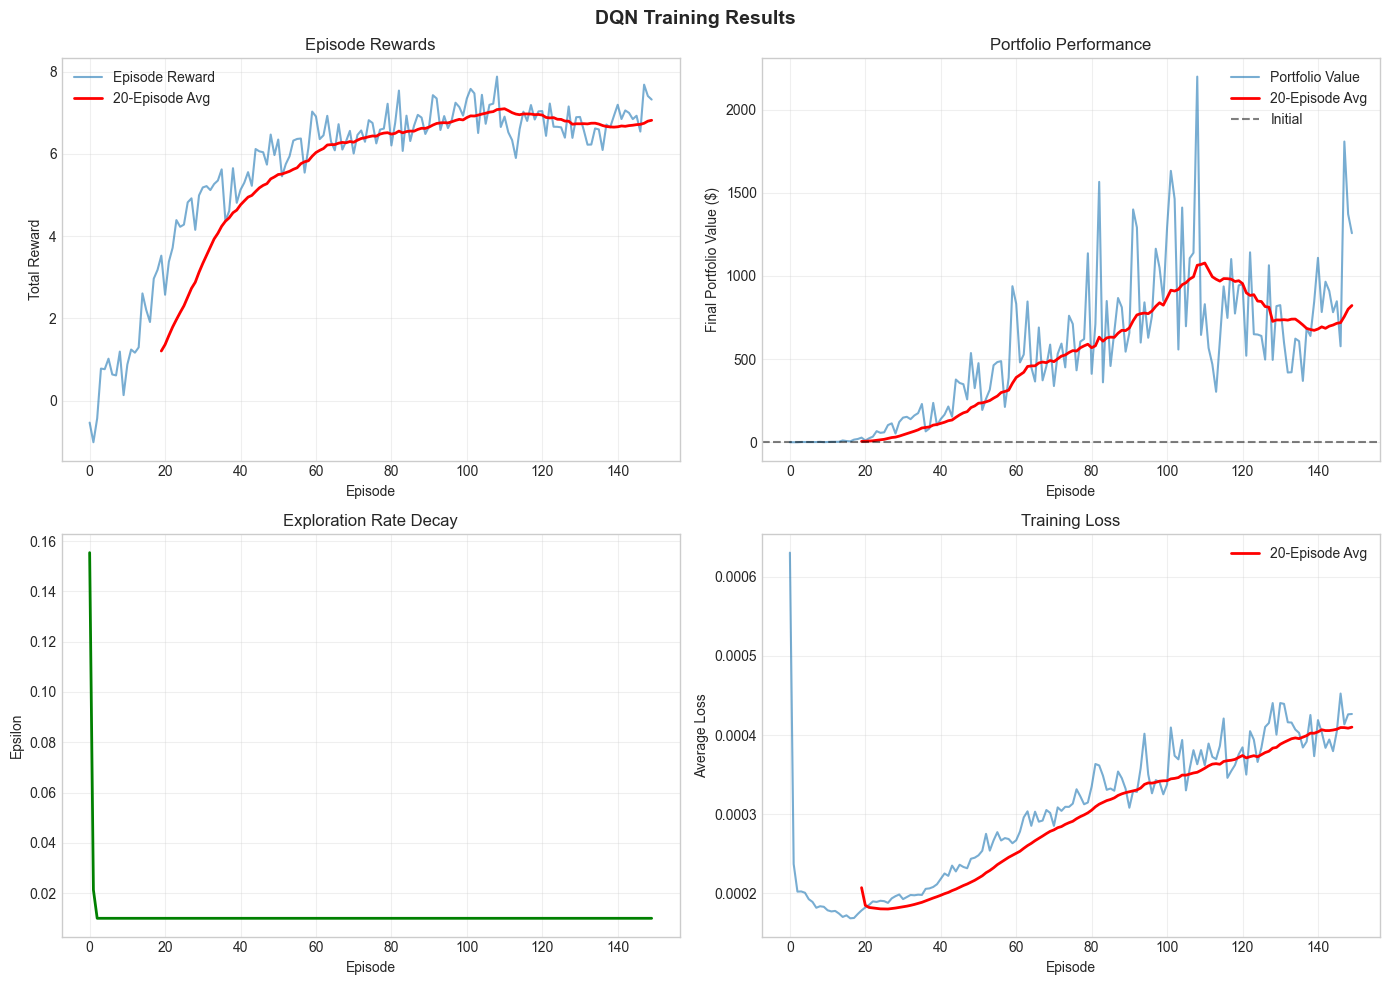

In [11]:
def plot_training_results(history: dict):
    """Plot training metrics."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Episode rewards
    axes[0, 0].plot(history['episode_rewards'], alpha=0.6, label='Episode Reward')
    # Rolling average
    window = 20
    rolling_avg = pd.Series(history['episode_rewards']).rolling(window).mean()
    axes[0, 0].plot(rolling_avg, 'r-', linewidth=2, label=f'{window}-Episode Avg')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Portfolio values
    axes[0, 1].plot(history['episode_values'], alpha=0.6, label='Portfolio Value')
    rolling_avg = pd.Series(history['episode_values']).rolling(window).mean()
    axes[0, 1].plot(rolling_avg, 'r-', linewidth=2, label=f'{window}-Episode Avg')
    axes[0, 1].axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Initial')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Final Portfolio Value ($)')
    axes[0, 1].set_title('Portfolio Performance')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Epsilon decay
    axes[1, 0].plot(history['epsilons'], 'g-', linewidth=2)
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Epsilon')
    axes[1, 0].set_title('Exploration Rate Decay')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Training loss
    axes[1, 1].plot(history['avg_losses'], alpha=0.6)
    rolling_loss = pd.Series(history['avg_losses']).rolling(window).mean()
    axes[1, 1].plot(rolling_loss, 'r-', linewidth=2, label=f'{window}-Episode Avg')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Average Loss')
    axes[1, 1].set_title('Training Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('DQN Training Results', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_training_results(history)

In [12]:
def evaluate_agent(agent: DQNAgent, env: TradingEnvironment, n_episodes: int = 10) -> dict:
    """
    Evaluate trained agent without exploration.
    
    Args:
        agent: Trained DQN agent
        env: Trading environment
        n_episodes: Number of evaluation episodes
        
    Returns:
        Evaluation metrics
    """
    results = {
        'portfolio_values': [],
        'total_rewards': [],
        'action_distributions': [],
        'all_histories': []
    }
    
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        actions_taken = []
        
        while not done:
            action = agent.select_action(state, training=False)  # Greedy
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            actions_taken.append(action)
            state = next_state
        
        results['portfolio_values'].append(info['portfolio_value'])
        results['total_rewards'].append(total_reward)
        results['action_distributions'].append(np.bincount(actions_taken, minlength=3))
        results['all_histories'].append(env.history.copy())
    
    return results


# Evaluate on test data
print("=" * 60)
print("EVALUATING TRAINED AGENT")
print("=" * 60)

# Generate test data (different from training)
test_prices = generate_prices(500, mu=0.0001, sigma=0.025)
test_env = TradingEnvironment(test_prices, window_size=5)

eval_results = evaluate_agent(agent, test_env, n_episodes=20)

print(f"\nEvaluation Results (20 episodes):")
print(f"  Average Portfolio Value: ${np.mean(eval_results['portfolio_values']):.4f}")
print(f"  Std Portfolio Value: ${np.std(eval_results['portfolio_values']):.4f}")
print(f"  Best Portfolio Value: ${np.max(eval_results['portfolio_values']):.4f}")
print(f"  Worst Portfolio Value: ${np.min(eval_results['portfolio_values']):.4f}")
print(f"  Win Rate (>$1): {100 * np.mean(np.array(eval_results['portfolio_values']) > 1):.1f}%")

EVALUATING TRAINED AGENT

Evaluation Results (20 episodes):
  Average Portfolio Value: $0.5332
  Std Portfolio Value: $0.0000
  Best Portfolio Value: $0.5332
  Worst Portfolio Value: $0.5332
  Win Rate (>$1): 0.0%


Best episode portfolio value: $0.5332


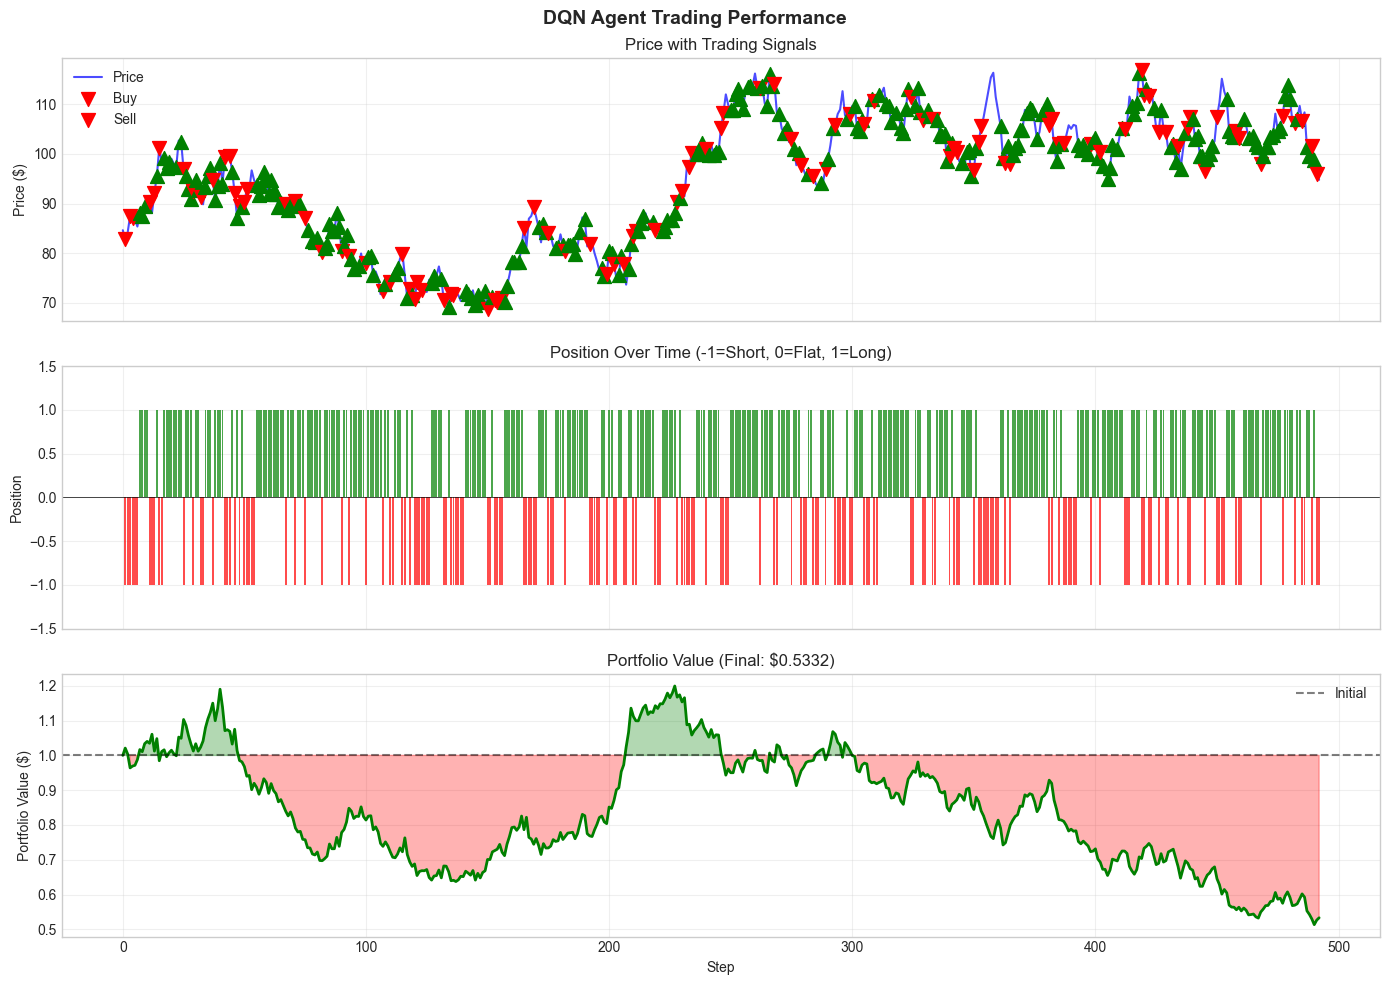

In [13]:
def plot_trading_episode(env: TradingEnvironment, history: list, title: str = "Trading Episode"):
    """
    Visualize a single trading episode.
    
    Args:
        env: Trading environment
        history: Episode history from environment
        title: Plot title
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    steps = [h['step'] for h in history]
    positions = [h['position'] for h in history]
    portfolio_values = [h['portfolio_value'] for h in history]
    actions = [h['action'] for h in history]
    
    # Price with buy/sell markers
    prices = env.prices[steps[0]:steps[-1]+1]
    axes[0].plot(range(len(prices)), prices, 'b-', alpha=0.7, label='Price')
    
    # Mark buy and sell actions
    for i, (step, action) in enumerate(zip(steps, actions)):
        if action == 1:  # Buy
            axes[0].scatter(i, prices[i], color='green', marker='^', s=100, zorder=5)
        elif action == 2:  # Sell
            axes[0].scatter(i, prices[i], color='red', marker='v', s=100, zorder=5)
    
    axes[0].set_ylabel('Price ($)')
    axes[0].set_title('Price with Trading Signals')
    axes[0].legend(['Price', 'Buy', 'Sell'])
    axes[0].grid(True, alpha=0.3)
    
    # Position over time
    position_colors = ['red' if p == -1 else 'green' if p == 1 else 'gray' for p in positions]
    axes[1].bar(range(len(positions)), positions, color=position_colors, alpha=0.7)
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_ylabel('Position')
    axes[1].set_title('Position Over Time (-1=Short, 0=Flat, 1=Long)')
    axes[1].set_ylim(-1.5, 1.5)
    axes[1].grid(True, alpha=0.3)
    
    # Portfolio value
    axes[2].plot(range(len(portfolio_values)), portfolio_values, 'g-', linewidth=2)
    axes[2].axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Initial')
    axes[2].fill_between(range(len(portfolio_values)), 1, portfolio_values, 
                         where=np.array(portfolio_values) > 1, alpha=0.3, color='green')
    axes[2].fill_between(range(len(portfolio_values)), 1, portfolio_values, 
                         where=np.array(portfolio_values) < 1, alpha=0.3, color='red')
    axes[2].set_xlabel('Step')
    axes[2].set_ylabel('Portfolio Value ($)')
    axes[2].set_title(f'Portfolio Value (Final: ${portfolio_values[-1]:.4f})')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Plot best evaluation episode
best_idx = np.argmax(eval_results['portfolio_values'])
print(f"Best episode portfolio value: ${eval_results['portfolio_values'][best_idx]:.4f}")

# Run one more episode to capture history for plotting
state = test_env.reset()
done = False
while not done:
    action = agent.select_action(state, training=False)
    state, reward, done, info = test_env.step(action)

plot_trading_episode(test_env, test_env.history, "DQN Agent Trading Performance")

COMPARISON WITH BASELINES

Strategy              Mean        Std     Sharpe   Win Rate
------------------------------------------------------------
DQN                 0.5332     0.0000 -740993753.90       0.0%
Buy & Hold          1.0471     0.0000 74701071.61     100.0%
Random              0.6558     0.4197     -13.02      12.0%
Momentum            0.5255     0.0000 -753276272.81       0.0%


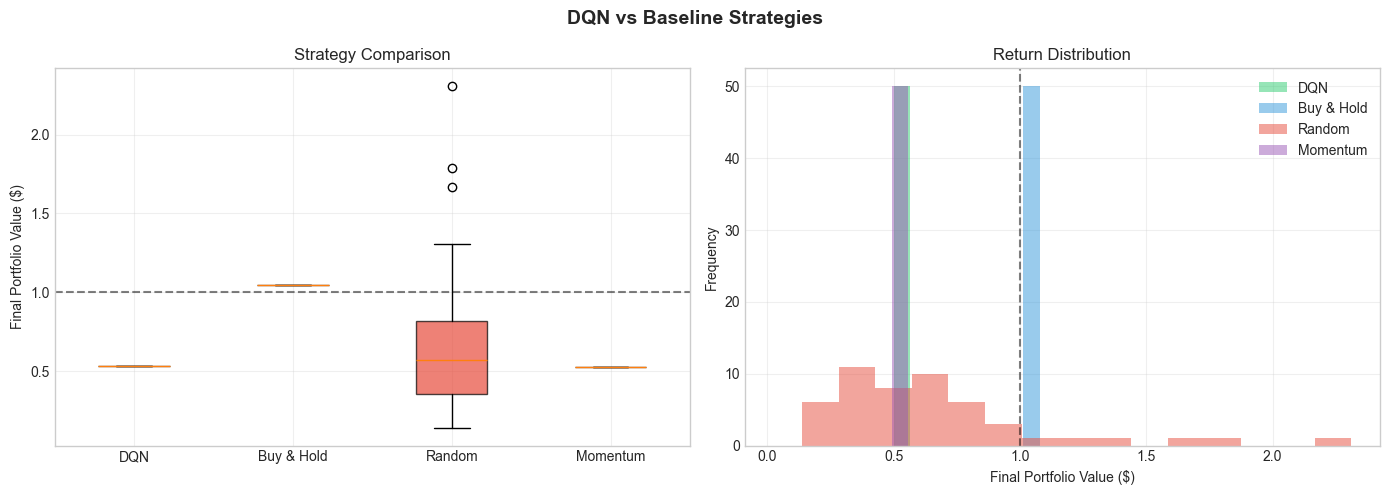

In [14]:
def compare_with_baselines(env: TradingEnvironment, agent: DQNAgent, n_episodes: int = 20):
    """
    Compare DQN agent with baseline strategies.
    
    Baselines:
    - Buy and Hold: Always long
    - Random: Random actions
    - Momentum: Follow recent trend
    """
    results = {
        'DQN': [],
        'Buy & Hold': [],
        'Random': [],
        'Momentum': []
    }
    
    for _ in range(n_episodes):
        # DQN Agent
        state = env.reset()
        done = False
        while not done:
            action = agent.select_action(state, training=False)
            state, _, done, info = env.step(action)
        results['DQN'].append(info['portfolio_value'])
        
        # Buy and Hold
        state = env.reset()
        done = False
        first_step = True
        while not done:
            action = 1 if first_step else 0  # Buy once, then hold
            first_step = False
            state, _, done, info = env.step(action)
        results['Buy & Hold'].append(info['portfolio_value'])
        
        # Random
        state = env.reset()
        done = False
        while not done:
            action = np.random.randint(0, 3)
            state, _, done, info = env.step(action)
        results['Random'].append(info['portfolio_value'])
        
        # Momentum
        state = env.reset()
        done = False
        while not done:
            momentum = state[4]  # Momentum feature from state
            if momentum > 0.01:
                action = 1  # Buy
            elif momentum < -0.01:
                action = 2  # Sell
            else:
                action = 0  # Hold
            state, _, done, info = env.step(action)
        results['Momentum'].append(info['portfolio_value'])
    
    return results


# Compare strategies
print("=" * 60)
print("COMPARISON WITH BASELINES")
print("=" * 60)

comparison = compare_with_baselines(test_env, agent, n_episodes=50)

# Summary statistics
print(f"\n{'Strategy':<15} {'Mean':>10} {'Std':>10} {'Sharpe':>10} {'Win Rate':>10}")
print("-" * 60)

for strategy, values in comparison.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    returns = np.array(values) - 1
    sharpe = np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)
    win_rate = 100 * np.mean(np.array(values) > 1)
    print(f"{strategy:<15} {mean_val:>10.4f} {std_val:>10.4f} {sharpe:>10.2f} {win_rate:>9.1f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
strategies = list(comparison.keys())
values = [comparison[s] for s in strategies]
bp = axes[0].boxplot(values, labels=strategies, patch_artist=True)
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].axhline(y=1.0, color='black', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Final Portfolio Value ($)')
axes[0].set_title('Strategy Comparison')
axes[0].grid(True, alpha=0.3)

# Distribution plot
for strategy, color in zip(strategies, colors):
    axes[1].hist(comparison[strategy], bins=15, alpha=0.5, label=strategy, color=color)
axes[1].axvline(x=1.0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Final Portfolio Value ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Return Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('DQN vs Baseline Strategies', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Part 5: Double DQN Enhancement

### The Overestimation Problem

Standard DQN tends to **overestimate** Q-values because:
- We use $\max_{a'} Q(s', a')$ which picks the maximum of noisy estimates
- Maximum of noise > true maximum

### Double DQN Solution

Use online network to **select** actions, target network to **evaluate**:

$$Q(s, a) \leftarrow r + \gamma Q\left(s', \arg\max_{a'} Q(s', a'; \theta); \theta^-\right)$$

In [15]:
class DoubleDQNAgent(DQNAgent):
    """
    Double DQN Agent - reduces overestimation bias.
    
    Key difference: Action selection and evaluation use different networks.
    """
    
    def train_step(self) -> Optional[float]:
        """
        Training step with Double DQN update.
        """
        if not self.memory.is_ready(self.batch_size):
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Compute current Q values
        current_q = self.online_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Double DQN: Use online network to SELECT actions, target network to EVALUATE
        with torch.no_grad():
            # Online network selects best actions for next states
            next_actions = self.online_network(next_states).argmax(1)
            
            # Target network evaluates those actions
            next_q = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss
        loss = F.smooth_l1_loss(current_q, target_q)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_network.parameters(), 1.0)
        self.optimizer.step()
        
        # Update target network
        self.training_step += 1
        if self.use_soft_update:
            soft_update(self.online_network, self.target_network, self.tau)
        elif self.training_step % self.target_update_freq == 0:
            hard_update(self.online_network, self.target_network)
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        
        loss_value = loss.item()
        self.losses.append(loss_value)
        
        return loss_value


print("=" * 60)
print("DOUBLE DQN")
print("=" * 60)
print("Double DQN reduces overestimation by decoupling action selection")
print("from action evaluation.")
print("\nStandard DQN: max_a' Q_target(s', a')")
print("Double DQN:   Q_target(s', argmax_a' Q_online(s', a'))")

DOUBLE DQN
Double DQN reduces overestimation by decoupling action selection
from action evaluation.

Standard DQN: max_a' Q_target(s', a')
Double DQN:   Q_target(s', argmax_a' Q_online(s', a'))


---
## Summary & Key Takeaways

### DQN Components

| Component | Purpose | Key Benefit |
|-----------|---------|-------------|
| **Neural Network Q-Function** | Approximate Q(s,a) | Handle continuous/high-dim states |
| **Experience Replay** | Store and sample experiences | Break correlation, reuse data |
| **Target Network** | Stable Q-value targets | Reduce training instability |
| **Epsilon-Greedy** | Balance exploration/exploitation | Discover optimal actions |

### DQN Algorithm

```
1. Initialize Q-network with random weights θ
2. Initialize target network with weights θ⁻ = θ
3. Initialize replay buffer D

For each episode:
    For each step:
        a. Select action using ε-greedy from Q(s, ·; θ)
        b. Execute action, observe reward r and next state s'
        c. Store (s, a, r, s', done) in D
        d. Sample mini-batch from D
        e. Compute target: y = r + γ max_a' Q(s', a'; θ⁻)
        f. Update θ by minimizing (Q(s, a; θ) - y)²
        g. Periodically update θ⁻ ← θ
```

### Trading-Specific Considerations

1. **State Design**: Include price returns, volatility, momentum, position
2. **Reward Shaping**: Account for transaction costs and risk
3. **Action Space**: Often discrete (Hold, Buy, Sell) or position sizing
4. **Training Data**: Use sufficient history with diverse market regimes

In [16]:
# Final summary visualization
print("=" * 60)
print("WEEK 16 DAY 4 COMPLETE: DEEP Q-NETWORKS")
print("=" * 60)

print("""
✅ Neural Network Q-Function
   - Approximate Q(s,a) with deep neural network
   - Handle continuous state spaces
   - Flexible architecture for trading features

✅ Experience Replay
   - Break temporal correlations
   - Efficient data reuse
   - Prioritized replay for important experiences

✅ Target Networks
   - Stabilize training with frozen targets
   - Hard vs soft updates
   - Reduce moving target problem

✅ DQN Trading Implementation
   - Complete environment with state/reward
   - Full DQN agent with all components
   - Comparison with baseline strategies

🔜 Next: Day 5 - Policy Gradient Methods & Actor-Critic
""")

WEEK 16 DAY 4 COMPLETE: DEEP Q-NETWORKS

✅ Neural Network Q-Function
   - Approximate Q(s,a) with deep neural network
   - Handle continuous state spaces
   - Flexible architecture for trading features

✅ Experience Replay
   - Break temporal correlations
   - Efficient data reuse
   - Prioritized replay for important experiences

✅ Target Networks
   - Stabilize training with frozen targets
   - Hard vs soft updates
   - Reduce moving target problem

✅ DQN Trading Implementation
   - Complete environment with state/reward
   - Full DQN agent with all components
   - Comparison with baseline strategies

🔜 Next: Day 5 - Policy Gradient Methods & Actor-Critic

